## Clasificacion de textos: 

## Importar Librerías

In [430]:
import pandas as pd
from sklearn import metrics
import nltk
import numpy as np
import string
import time 

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


In [431]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparando los datos:

In [432]:
# obtenemos los datos de entrenamiento
train_dataset = pd.read_csv("text_classification_train.csv")
# obtenemos los datos de testeo
test_dataset = pd.read_csv("text_classification_test.csv")

In [433]:
# obtenemos una lista de los labels a utilizar: 
labels = open("emotions.txt", "r").read().splitlines()

## Procesamiento y análisis de los datos: 
En primera instancia al momento de analizar el dataset, es importante resolver ciertas preguntas: 
<ol>
  <li>¿Está balanceado el dataset? De no estarlo, ¿Que tan desbalanceado está?</li>
  <li>¿Existen palabras que tengan una ocurrencia mayor en el dataset?</li>
</ol>
A través de la sección de análisis resolveremos dichos problemas. 

# Análisis de la columna de emociones: 
Una parte importante de este problema es la manera en que se encuentran clasificados los textos generados. Como se indica en el enunciado del problema esto fue hecho por personas y es posible encontrar errores, de este modo, debemos analizar si existen errores o no en estos registros. 

De este modo, en primera instancia, si los registros estuvieran correctos al ver los valores únicos que presenta el dataframe debieramos encontrar solamente 28 valores y nada más. De no ser así se tendrá que ver cuales de estos registros están erróneos o con un formato diferente. 

In [434]:
# revisamos si es que existen textos vacios: 
(train_dataset.text.str.len()==0).any()

False

In [435]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [436]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [437]:
pd.unique(train_dataset["emotion"]).shape

(711,)

Revisando estos resultados, encontramos que la cantidad de clases que presenta la columna de emociones es cerca de 711, lo cual dista considerablemente de los 28 que deberíamos encontrar. De este modo, veamos los más comunes de estos.

In [438]:
emotion_counter = Counter(train_dataset["emotion"])
print(emotion_counter.most_common(30))

[('27', 12823), ('0', 2710), ('4', 1873), ('15', 1857), ('1', 1652), ('3', 1451), ('18', 1427), ('10', 1402), ('7', 1389), ('2', 1025), ('20', 861), ('6', 858), ('17', 853), ('25', 817), ('26', 720), ('9', 709), ('5', 649), ('22', 586), ('13', 510), ('11', 498), ('14', 430), ('8', 389), ('24', 353), ('2,3', 230), ('0,15', 227), ('12', 203), ('0,4', 199), ('4,27', 190), ('6,7', 174), ('0,18', 155)]


Entre los valores más comunes de emociones existen algunos que representan dos o más emociones. Esto nos indica que no es posible utilizar los labels para realizar aprendizaje multi-clase. Esto ya que en un problema multiclases es necesario que cada registro tenga solamente una sola categoría. De este modo, para poder abordar el problema de una manera en que se puedan identificar más de una categoría será necesario adecuar el modelo a este tipo de estructura del problema.

Primero, como se indicó en el enunciado que los labels están sometidos a posibles errores, lo que haremos será revisar con ejemplos si es que las frases que tienen más de una catalogación calzan con dichas etiquetas. 

In [439]:
# agregaremos una columna a los datos que nos diga la cantidad de labels que este tiene:
train_dataset["amount emotions"] = train_dataset["emotion"].apply(lambda x: len(x.split(",")))
train_dataset["text_emotions"] = train_dataset["emotion"].apply(lambda x: ",".join([labels[int(i)] for i in x.split(",")]))
solo1 = sum(train_dataset["amount emotions"]==1)
total_emotions = train_dataset.shape[0]
amount_emotions = {"solo 1": solo1/total_emotions, ">1": 1-(solo1/total_emotions)}

Dentro de esta línea es importante saber que porcentaje de los labels tienen más de una catalogación, para así saber si es posible por ejemplo, eliminarlos del dataset. 

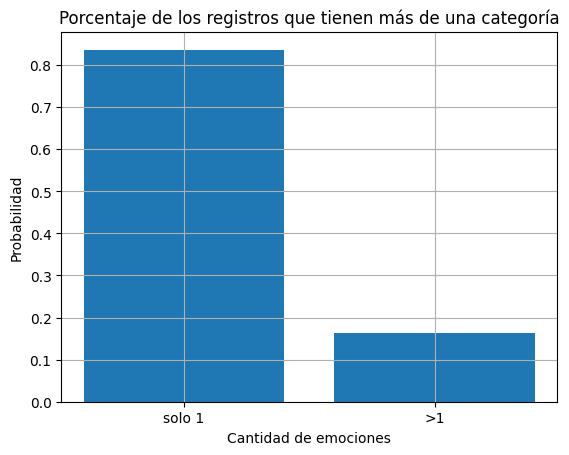

In [440]:

fig, ax = plt.subplots()
ax.grid()
ax.bar(amount_emotions.keys(), amount_emotions.values())
ax.set_title("Porcentaje de los registros que tienen más de una categoría")
ax.set_xlabel("Cantidad de emociones")
ax.set_ylabel("Probabilidad")
plt.show()

Como se puede ver anteriormente, el porcentaje de datos etiquetados con múltiples etiquetas corresponden a cerca del 15% de los datos, a pesar de ser un porcentaje minoritario,no es posible descartar de plano ya que puede ser parte fundamental de las funcionalidades que espera el cliente de este modelo.  Ahora, si es que dichas catalogaciones mostraran algún grado de error en su construcción también podría ser factible eliminarlas del conjunto de datos, pero mientras esto no se demuestre no se aplicará dicha medida. 

In [441]:
multi_label_data = train_dataset[train_dataset["amount emotions"]>1]

Veamos algunos ejemplos de los textos que se encuentran catalogados como multiclase:

In [442]:
import random
for _ in range(10): 
    i = random.randint(0, multi_label_data.shape[0]-1)
    print(f"text: {multi_label_data.iloc[i].text}, emotions: {multi_label_data.iloc[i].text_emotions}")

text: I've never been so proud of humanity., emotions: pride,neutral
text: Wow, now that you say that . Although, we do have [NAME], South Park, Family Guy and American Dad now. Mmmmm, [NAME], emotions: excitement,realization
text: Yeah feel bad for people paying 200 to watch this crap. Better hockey watching my sons novice games., emotions: annoyance,disgust
text: thank you for taking the time to answer, im freaking out big time, emotions: annoyance,gratitude
text: I was listening to look alive by [NAME] and [NAME] and it was perfect timing with this video and the song😂😂, emotions: admiration,approval
text: I like this title, fun to picture a violent lake stealing dogs! :), emotions: admiration,amusement
text: I hope that you find happiness, too. I'm happy that you've had a place to vent., emotions: joy,optimism
text: Twenty some years ago, while I was pregnant with my son, TLC aired shows like A Baby's Life. Oh, the old days..., emotions: excitement,joy
text: Eagles fan here. is this

Haciendo una revisión de los textos que se encuentran ejemplificados, se puede notar a simple vista que las etiquetas están correctas, ahora, como estos son solamente 10 datos, dicha ejemplificación no es representativa de todos los datos. Por esto es necesario realizar una matriz de correlación para los casos multi-etiqueta y revisar si es posible encontrar algún tipo de patrón en los datos. 

In [443]:
# matriz binaria que permita saber las categorizaciones multiples que pueda tener cada registro:
def binarize_labels(df):
    N_categories = 28
    N_registries = df.shape[0]

    binary_matrix = np.zeros((N_registries, N_categories))
    for i, a_emotion in enumerate(df["emotion"].tolist()):
        category_list = list(map(int, a_emotion.split(",")))
        binary_matrix[i, category_list] = 1
    B_df = pd.DataFrame(binary_matrix, columns=[f"label_{i}" for i in range(N_categories)])
    # append to dataset: 
    df = df.join(B_df)
    return df


def generate_correlation_matrix(data, labels,  multilabel=False):
    # funcion que permite generar la matriz de correlacion para tanto etiquetas totales o solamente el caso de multi etiquetas. 
    if multilabel:
        # el caso de multilabel se hace un filtrado en la cantidad de emociones de manera de quedarnos solamente con dichos resultados. 
        # y calculamos la matriz de correlacion
        corr = data[train_dataset["amount emotions"]>1][[f"label_{i}" for i in range(len(labels))]].corr()
    else: 
        # en caso contrario se utilizan todos los labels para el calculo de la matriz de correlacion
        corr = data[[f"label_{i}" for i in range(len(labels))]].corr()
    plot_correlation_matrix(corr, labels)


def plot_correlation_matrix(corr_matrix, labels):
    # hacemos una mascara que genere un triangulo diagonal inferior. 
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # generamos la figura
    fig, ax = plt.subplots(figsize=(11,9))
    # seteamos los colores
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # generamos el mapa de calor con la matriz de correlacion
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    ax.set_title("Label Correlation Matrix")


Separamos los labels por columnsas de manera de simplificar el cálculo de la matriz de correlacion.

In [444]:
train_dataset = binarize_labels(train_dataset)

graficamos la matriz de correlacion a continuación: 

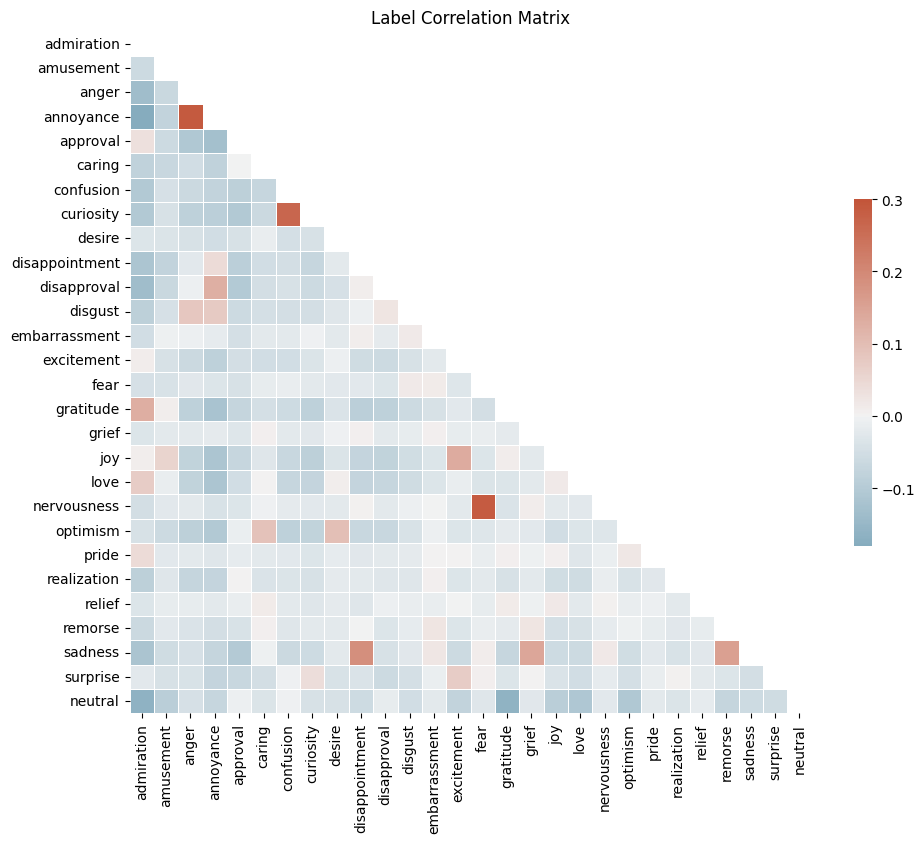

In [445]:
generate_correlation_matrix(train_dataset, labels, multilabel=True)

Observando la imagen anterior, se puede notar que las correlaciones existentes entre las distintas etiquetas existen pero no son fuertes, si es que hubiesen habido correlaciones fuertes una posible aproximación al problema hubiese sido hacer una fusión entre dichas variables, pero no es el caso. De todos modos, la figura nos permite ver que las correlaciones encontradas calzan con las emociones a las que representan por ejemplo. Podemos notar que una relación positiva existe entre: annoyance y anger, Curiosity y Confusion, Nervousness y fear, Sadness y dissapointmente, sadness y grieff, entre otros. 

Además, se puede ver que existen correlaciones negativas entre palabras que tienen significados excluyentes entre ellos. De este modo, podemos ver que anger y admiration tienen una correlación negativa, gratitud y neutral también.

Con lo analizado hasta ahora podemos concluir en primera instancia que los valores que tienen múltiples etiquetas están bien catalogadas, ya que a través de su matriz de correlación se observan relaciones que son correctas entre las palabras. Si la catalogación fuese erróneos entonces esta correlación entre etiquetas no sería tal. 

Ahora, revisando la matriz de correlación también es posible ver que las palabras que tienen una connotación general positiva como son por ejemplo "admiration", "amusement", "approval" tienen o una correlación positiva o una correlación cero, no existen casos de palabras con connotaciones positivas con correlaciones negativas. Lo mismo ocurre para los casos de connotación negativa y neutra. De este modo y para enriquecer el análisis, es posible revisar si dichas palabras contienen particularidades especiales. 

In [446]:
POSITIVE_LABELS = ["admiration", "amusement", "approval", "caring", "desire", "excitement", "gratitude", "joy", "love", "relief"]
NEGATIVE_LABELS = ["anger", "annoyance", "disappointment", "disgust", "embarrassment","fear", "grief", "remorse", "sadness"]
NEUTRAL_LABELS = ["confusion", "curiosity", "nervousness", "surprise", "neutral"]

def generate_super_label_ids(dataset):
    POSITIVE_id = dataset[[f"label_{labels.index(a_label_name)}" for a_label_name in POSITIVE_LABELS]].any(axis=1)
    NEGATIVE_id =  dataset[[f"label_{labels.index(a_label_name)}" for a_label_name in NEGATIVE_LABELS]].any(axis=1)
    NEUTRAL_id = dataset[[f"label_{labels.index(a_label_name)}" for a_label_name in NEUTRAL_LABELS]].any(axis=1)
    return POSITIVE_id, NEGATIVE_id, NEUTRAL_id

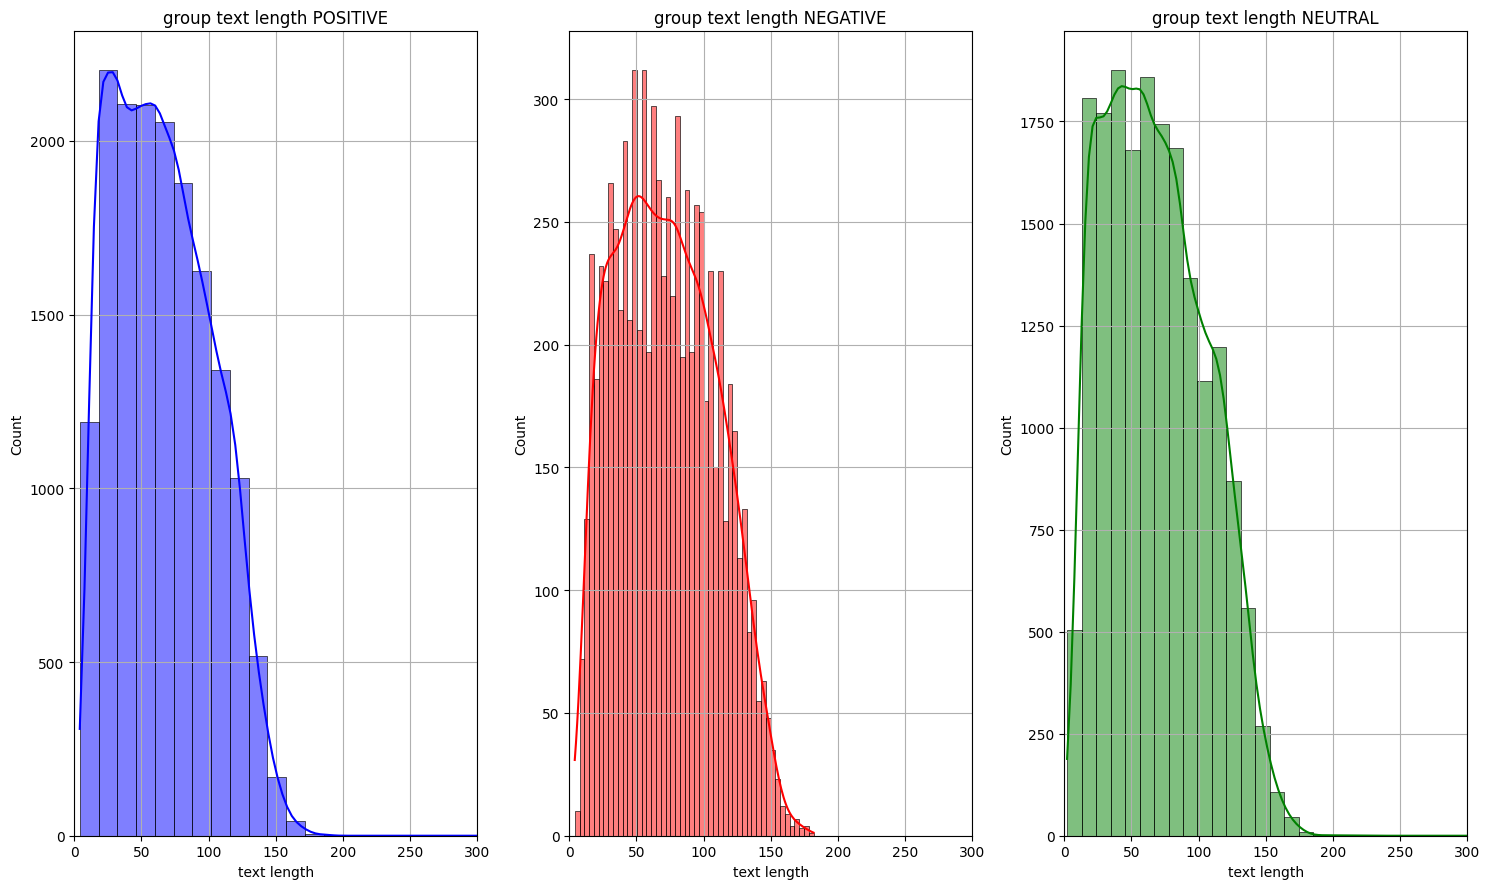

In [447]:


ncols = generate_super_label_ids(train_dataset)
names = ["POSITIVE", "NEGATIVE", "NEUTRAL"]
colors = ["blue", "red", "green"]
fig, ax = plt.subplots(nrows=1, ncols=len(ncols), figsize=(15, 9))


for i in range(len(ncols)): 
    sns.histplot(train_dataset[ncols[i]].text.str.len(), kde=True, bins=50, alpha=0.5,  ax= ax[i], color=colors[i])
    ax[i].set_title(f"group text length {names[i]}")
    ax[i].set_xlim(xmin=0, xmax=300)
    ax[i].set_xlabel("text length")
    ax[i].grid()
plt.tight_layout()

En la figura anterior se graficaron los largos de los textos hasta 300 de largo. Es posible observar cómo las palabras con una connotación o "super-etiqueta" positiva tienen una media más baja que los textos con connotaciones negativas o neutras. En este mismo caso se puede ver además cómo los textos con una connotación negativa tiene una variación menor en su largo que los casos con connotaciones positivas o neutras, esto se puede ver con el largo de los bins, ya que todas las figuras son generadas con la misma cantidad de bins (50), pero la única que los tiene un histograma más corto en ancho es el histograma de connotación negativa. De este modo, podemos ver que los textos con una connotación positiva y neutra presentan una mayor variabilidad en sus largos, pero dicha variación no se ve acompañada con una frecuencia alta, sino que con casos esporádicos. 

## Etiquetas y su distribución

Para saber  como están distribuidas las clases con etiquetas multiples y las que aparecen una sola vez, es necesario saber como distribuyen las etiquetasy sus posibles combinaciones. Esto permitirá entender que tan desbalanceadas están las clases entregadas en el dataset.  

De este modo, iniciamos este análisis haciendo un análisis solamente de cada etiqueta y su frecuencia. Como se puede observar en la figura la cantidad de texto neutro en la imagen es cerca de 3 veces mayor a la segunda etiqueta con más frecuencia. Además, se puede ver que salvo la etiqueta neutra, "admiration", "amusement" "annoyance", "approval", "curiosity", "gratititude" y "love" son las únicas que pasan de los 2000 registros, siendo estos aproximadamente 6 veces menos frecuentes en el dataset. De este modo, podemos ver que el dataset se encuentra clarametne desbalanceado. 

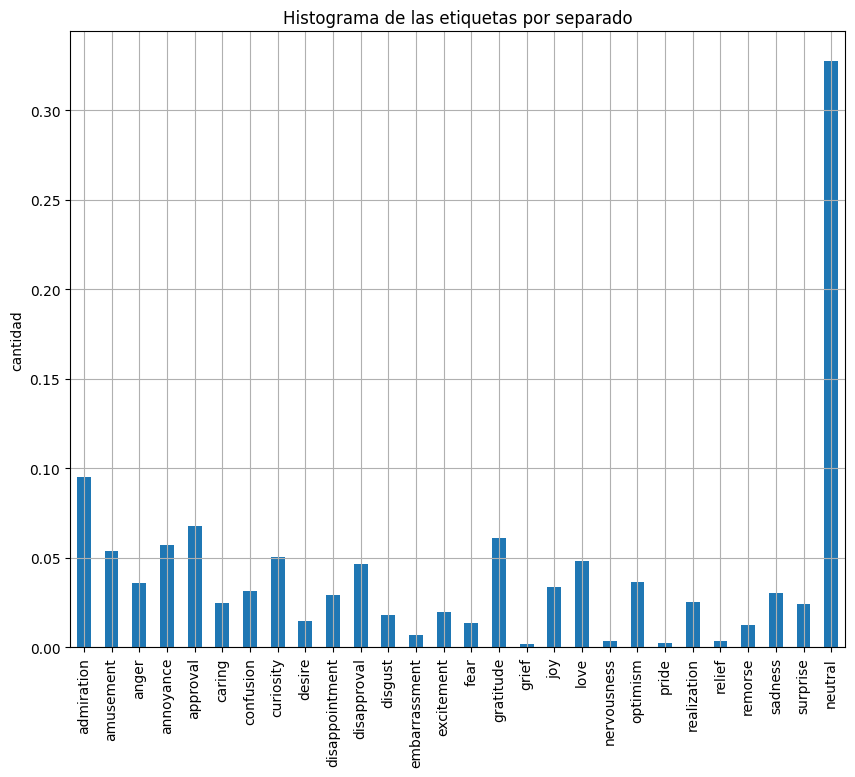

In [448]:
fig, ax = plt.subplots(figsize=(10, 8))
(train_dataset[[f"label_{i}" for i in range(28)]].sum()/train_dataset.shape[0]).plot(kind="bar", ax=ax, title="Histograma de las etiquetas por separado", ylabel="cantidad")
ax.set_xticklabels(labels)
plt.grid()

Ahora, otro punto interesante es como se distribuyen las etiquetas considerando las combinaciones cómo etiquetas propias y así ver como es que se distribuyen además las combinaciones. Acá podemos ver cómo es que combinaciones como el anger, annoyance tiene una mayor frecuencia en el dataset en conjunto que etiquetas cómo embarrassment. Esto muestra nuevamente el desbalance presente en los datos, ya que incluso combinaciones de etiquetas diferentes tienen una frecuencia mayor que etiquetas solas, esto recalca el hecho de que no es posible eliminar las etiquetas múltiples, definiendo así que el problema debe ser tratado como un problema de etiquetas múltiples. 

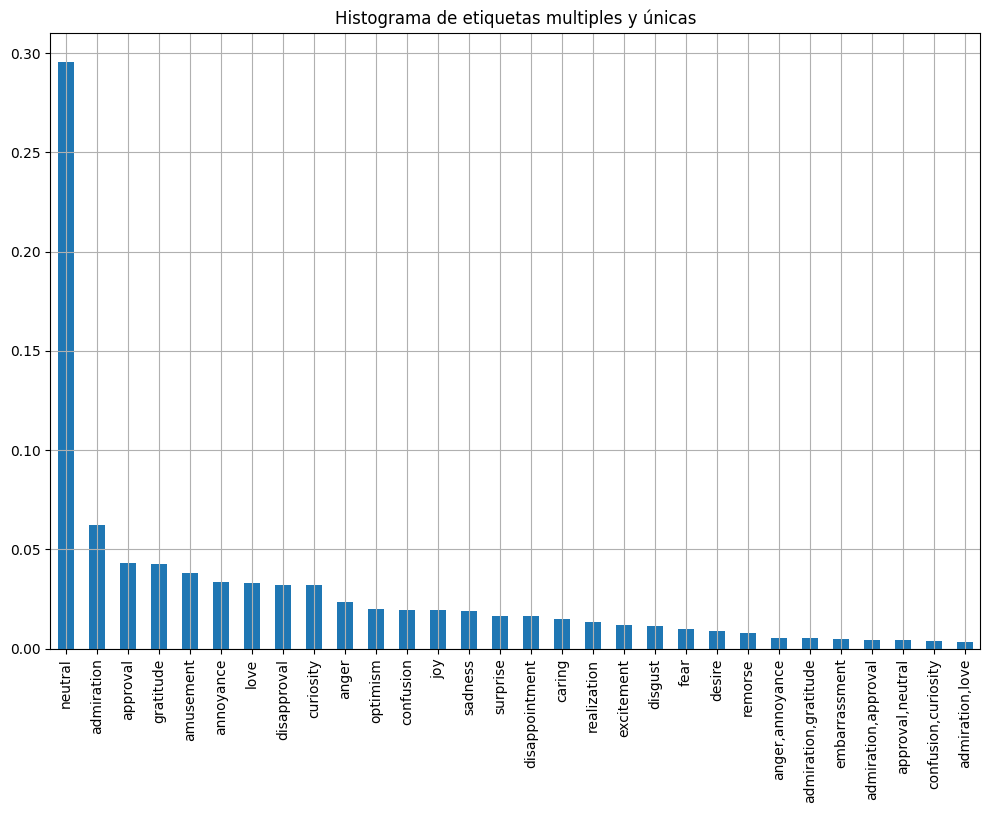

In [449]:
fig, ax = plt.subplots(figsize=(12, 8))
(train_dataset["text_emotions"].value_counts()[:30]/train_dataset.shape[0]).plot(kind="bar", title="Histograma de etiquetas multiples y únicas", ax=ax)
plt.grid()

## Balanceando los datos:
Como se mencionó anteriormente, los datos de entrenamiento presentan un desbalance claro en específico la clase neutra se encuentra sobrerepresentada en los datos a tal punto que es incluso 6 veces más frecuente que otras emociones en el dataset. Si se intentara entrenar un modelo con el desbalance presente en los datos lo más probable es que dicho modelo solamente buscará predecir la clase neutra dejando de lado otras clases menos frecuentes, es por esto que es necesario balancear los datos. 

Para este caso haremos uso de over-sampling y under-sampling. En específico definiremos un número de muestras que buscamos tener por clase, dicho número contabiliza solamente la ocurrencia de esa clase en específico, por lo que los registros que se les genera over-sampling pueden ser perfectamente registros que tengan más de una etiqueta, esto permite no afectar de manera específica las distribuciones de otros conjuntos de etiquetas presentes en el dataset. De este modo, todas las etiquetas que tengan un número menor de muestras que las pedidas para hacer este proceso sufrirán de over-sampling, mientras que toda etiqueta que tenga una cantidad mayor a las muestras pedidas sufrirá de undersampling. De este modo, nos aseguramos que las cantidades encontradas sean efectivamente iguales y así evitamos que el modelo se sobre ajuste a una de las etiquetas. 

In [450]:

def balance_one_class(data, amount_of_samples):
   '''balance_one_class:

    Este metodo genera los indices que posteriormente serán duplicados o eliminados del dataframe, 
    considerar que en caso de que el numero de muestras sea mayor a las muestras presentes en el dataset
    entonces este la seleccion de indices se hara con repeticion, mientras que en el caso contrario esta se 
    hara sin repeticion
    inputs: 
    data (pd.DataFrame): datos que se les quiere hacer over-sampling o under-sampling 
                        ya filtrados por una clase en especifico.
    amount_of_samples (int): Cantidad de muestras que se busca generar

    output: 
    sampled_indexes (list): lista de integers que representan los indices que se duplicaran o eliminaran del 
    dataframe
   
   '''
   delta_amount_of_samples = amount_of_samples - data.shape[0]
   replace = delta_amount_of_samples>0
   delta_amount_of_samples = abs(delta_amount_of_samples)
   indexes = data.index
   sampled_indexes = np.random.choice(indexes, size=delta_amount_of_samples, replace=replace)

   return sampled_indexes.tolist()


def balance_dataset(dataset, amount_of_samples):
    '''
    balance_dataset: 

    este metodo balancea un dataframe multi-clase o multi-etiquetas iterando por cada una de las columnas, lo unico
    que se pide es que se tenga una columna por cada uno de las etiquetas o clases. Una vez filtrados las etiquetas 
    se eligen aleatoriamente indices para duplicar o eliminar. 

    inputs: 
    inputs: 
    data (pd.DataFrame): datos que se les quiere hacer over-sampling o under-sampling 
                        ya filtrados por una clase en especifico.
    amount_of_samples (int): Cantidad de muestras que se busca generar

    output: 
    dataset (pd.Dataframe): data frame con las clases balanceadas. 

    '''
    # copiamos el dataset
    dataset = dataset.copy()
    # generamos las columnas
    labels = [f"label_{i}" for i in range(28)]
    for a_label in labels:
        # filtramos los datos
        label_data = dataset[dataset[a_label]==1]
        # revisamos si hay que realizar under o over-sampling
        over = amount_of_samples>label_data.shape[0]       
        # generamos los indices aleatorios
        resample_indexes = balance_one_class(label_data, amount_of_samples)
        if over:
            # hacemos oversampling
            copied_data = dataset.iloc[resample_indexes]
            dataset = pd.concat([dataset, copied_data]).reset_index(drop=True)
        else: 
            # hacemos under-sampling
            dataset = dataset.drop(resample_indexes).reset_index(drop=True)
    return dataset


In [451]:
# antes de hacer el balance de los datos extraeremos los datos de testing, como el balance del conjunto de datos genera un cambio en la distribución
# para poder validar los resultados encontrados es necesario guardar una porción de los datos que mantenga la distribución original. 
_, X_test, _, y_test = train_test_split(train_dataset["text"], train_dataset[[f"label_{i}" for i in range(28)]], shuffle=True, test_size=0.2, random_state=1)

In [452]:
balanced_train_dataset = balance_dataset(train_dataset, 5000)

Una vez balanceado el conjunto de entrenamiento se puede ver lo siguiente: si se hace una gráfica de la frecuencia de las etiquetas presentes en el dataset, uno podría percibir que efectivamente ahora los datos se encuentran más distribuidos y balanceados que antes, pero viendo la columna neutra se puede observar que esta bajó considerablemente su frecuencia. Esto se debe a la manera en que se realizó el muestreo, ya que no considerar solamente registros con etiqueta única permite aumentar la frecuencia de otras etiquetas en los casos donde existen etiquetas múltiples. Ahora, como el problema es un problema de multi-etiqueta y no de multi clase, en específico no es interesante ver la distribución de las etiquetas por separado, sino que la distribución de las etiquetas en conjunto. De este modo, si se observa la imagen subsiguiente se podrá ver este efecto. 

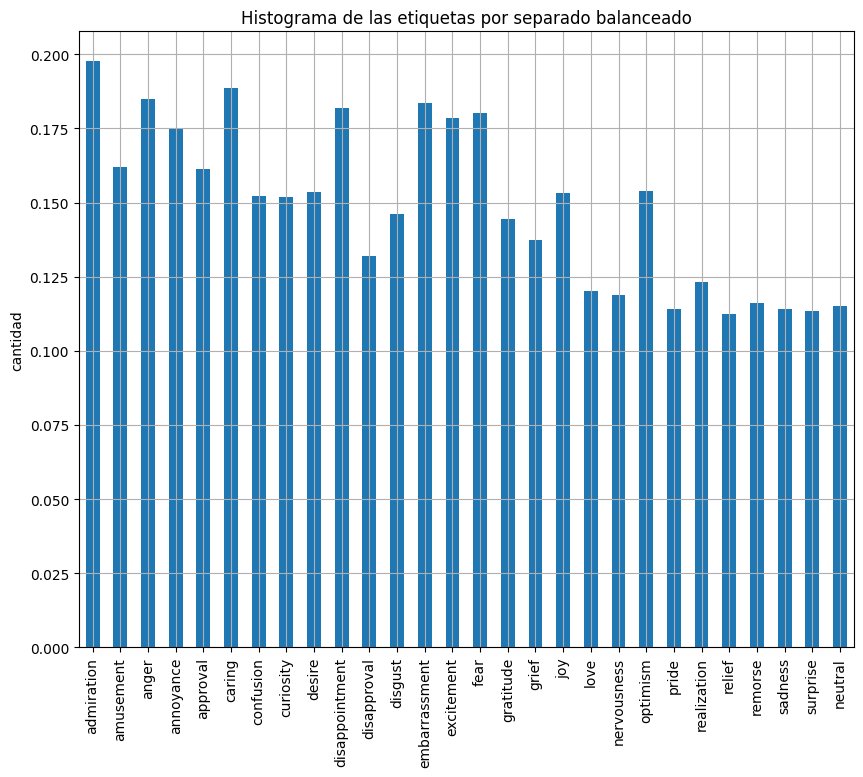

In [453]:
fig, ax = plt.subplots(figsize=(10, 8))
(balanced_train_dataset[[f"label_{i}" for i in range(28)]].sum()/train_dataset.shape[0]).plot(kind="bar", ax=ax, title="Histograma de las etiquetas por separado balanceado", ylabel="cantidad")
ax.set_xticklabels(labels)
plt.grid()

La imagen muestra cómo es que al momento de graficar las etiquetas únicas y múltiples la etiqueta neutral es la que más prevalece en el dataset, pero en una cantidad considerablemente menor. De este modo, la distribución de las etiquetas que serán las utilizadas durante el entrenamiento mantuvieron hasta cierto punto la manera en que los datos anteriormente se distribuían, pero entregando una mayor distribución ahora a las etiquetas que se encuentran solas, esto es efecto simplemente de la manera en que se muestrearon los datos. A pesar de este cambio, es importante notar que de no haberse hecho no era factible que el clasificador pudiese rendir de buena manera, debido al desbalance presente en los datos.

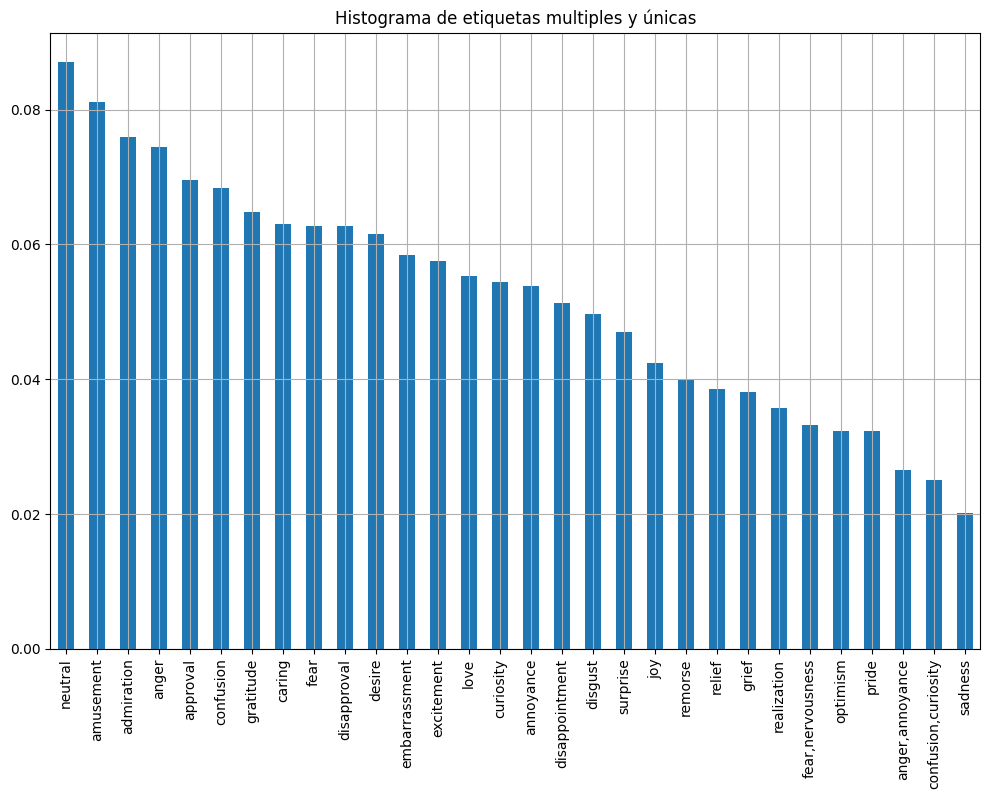

In [454]:
fig, ax = plt.subplots(figsize=(12, 8))
(balanced_train_dataset["text_emotions"].value_counts()[:30]/train_dataset.shape[0]).plot(kind="bar", title="Histograma de etiquetas multiples y únicas", ax=ax)
plt.grid()

## Preprocesamiento Texto

Una parte importante de los modelos que realizan procesamiento de lenguaje natural se encuentra en el pre procesamiento de los datos. Esto es especialmente importante en la aproximación que se hará del problema, esto ya que parte importante de la tarea en cuestión es realizar un modelo que no utiliza redes neuronales. Como hoy en día la mayoría de los métodos que generan características desde texto utilizan redes neuronales la manera en que generamos características de los textos es mediante métodos de frecuencia de palabras en documentos, en específico una variante de bag of words llamada tf-idf vectorizer, este método permite considerar tanto la frecuencia de las palabras en un texto y la rareza o importancia de la palabra en dicho texto.  


En específico lo que hace este método es calcular la frecuencia de cada palabra en el texto para luego calcular un índice de frecuencia de documentos a la inversa, de este modo cada uno de estos términos se calcula de la manera siguiente: 

$$TF(t) = \frac{\text{número de veces que t aparece en los documentos}}{\text{número de términos en los documentos}}$$

$$idf(t) = \frac{log(\text{ número de documentos})}{\text{número documents con término t}}$$ 

De este modo, este método permite sopesar que tan frecuente es un término junto con que tan normal o raro es que aparezca dicho término en el documento. De este modo, esta es una manera de poder generar características numéricas desde texto que permitan generar una clasificación en dicho modelo.

Encontrar una manera de generar valores numéricos desde texto no es lo único importante al momento de procesarlo, existen palabras que no aportan mucho en el contenido del texto pero son muy frecuentes en el mismo, a estas palabras se les denomina "stop words", estas palabras son conectores que permiten entender la frase pero en muchos casos no son necesarios para entender el contenido del mismo. En esta misma línea, como los métodos que utilizaremos están basados en frecuencia,puede ser necesario aplicar métodos que nos permitan utilizar la raíz más básica de la palabra en vez de la palabraa en si, por ejemplo, la raiz de la palabra happy y happyness es happi. Esto permite que los textos procesados no contengan una gran cantidad de términos sino que esta se vea reducida al utiliza la raíz en vez de la palabra en sí. 

Ahora, en muchos casos dicho pre procesamiento puede no ser tan necesario para la clasificación del texto ya que reducir palabras a una palabra raíz específica genera que se pierdan ciertos contenidos dentro del texto. Es por esto que dejaremos ambos casos y entrenaremos el mejor modelo con los casos procesados con la eliminación de stop words y stemming, además de los casos sin realizar dicho procesamiento. 

In [455]:

def text_list_tokenizer(text_list):
    """
    La funcion text_list_tokenizer crea una lista de tokens desde un texto. En especifico pasara desde 
    una lista de textos a una lista que contiene listas de tokens

    INPUTS:
    text_list(list[string]): a list of texts
    
    RETURNS:
    tokenized_list (list): a list of lists  
    """
    # generamos una lista donde guardaremos la lista de tokens
    tokenized_list = list()
    # creamos un objeto TweetTokenizer el que permita pasar de texto a una lista de tokens

    # preserve case: mantiene las mayusculas, en este caso al no ser parte fundamental del mensaje se
    # prefiere que todas queden en minuscula. 

    # strip_handles: al ser un objeto hecho para tweets esta condicion elimina cualquier # de usuarios.

    # reduce_len: hace que cualquier caracter o palabra que se presente de forma consecutiva quede limitada a tres repeticiones
    # por ejemplo !!!!!! pasaria a ser !!!
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    # iteramos sobre la lista de textos
    for a_text in text_list: 
        # tokenizamos y guardamos.
        tokenized_list.append(tokenizer.tokenize(a_text))

    return tokenized_list


def fix_characters(text_list): 
    # funcion que cambia numeros por el caracter [NUMBER]
    for i in range(len(text_list)):
        text_list[i] = re.sub("\d+", "NUMBER", text_list[i])
    return text_list

def clean_stem_tokenized_list(tokenized_list): 
    """
    La funcion clean_tokenized_list realiza una limpieza y steming sobre los tokens, extrayendo 
    todos los tokens que esten en stopwords o se encuentren en la lista de puntuacion. 
    
    """
    # generamos una lista para guardar las listas limpias
    cleaned_tokenized_list = list()
    # importamos los stopwords y las puntos. 
    stop_word_list = stopwords.words("english")
    puntuations = string.punctuation
    stemer = SnowballStemmer("english")
    # recorremos la lista de listas de tokens
    for a_token_list in tokenized_list:
        # generamos una nueva lista donde guardaremos los tokens limpios
        cleaned_token_i_list = list() 
        # recorremos los tokens
        for a_token in a_token_list:
            # solamente guardamos los limpios
            if not (a_token in stop_word_list or a_token in puntuations):
                cleaned_token_i_list.append(stemer.stem(a_token))
        # guardamos la lista limpia. 
        cleaned_tokenized_list.append(cleaned_token_i_list)
    return cleaned_tokenized_list

def get_maximum_number_tokens(token_list): 
    len_token = map(len, token_list)
    return max(len_token)


def token_2_text(token_list): 
    return list(map(lambda x: " ".join(x), token_list))



def preprocess_text(df_text_column):
    train_text_list = df_text_column.tolist()
    # tokenizamos esta lista
    train_text_list = fix_characters(train_text_list)
    tokenized_list = text_list_tokenizer(train_text_list)
    # limpiamos la lista
    cleaned_token_list = clean_stem_tokenized_list(tokenized_list) 
    # devolvemos el resultado como texto: 
    return token_2_text(cleaned_token_list)

In [456]:
# pasamos los datos de entrenamiento a una lista de texto
text = balanced_train_dataset.text
balanced_train_dataset["preprocessed_text"] = preprocess_text(text)

# preprocess test set: 
X_test_prep = preprocess_text(X_test)



In [457]:
POSITIVE_id, NEGATIVE_id, NEUTRAL_id = generate_super_label_ids(balanced_train_dataset)

## stemming y sus efectos en las nubes de palabras: 
Una vez procesados los datos se busca generar nubes de palabras para entender como están compuestas las "super-etiquetas", de este modo, veremos como la "super-etiqueta" positiva está compuesta de palabras como love, wish, good, entre otros, mientras que la "super-etiqueta" negativa está compuesto de palabras como bad, sorri, shame, entre otros. Por último, la "super-etiqueta" neutral no presenta palabras que tengan una connotación de por si positiva o negativa en su nube de palabras. Por esto se cree que la segmentación de las etiquetas en "super-etiquetas" no es solamente útil para entender de manera más simple como están compuestas estas etiquetas múltiples, sino que además se puede ver que es una estructura que se ve avalada por los datos. 

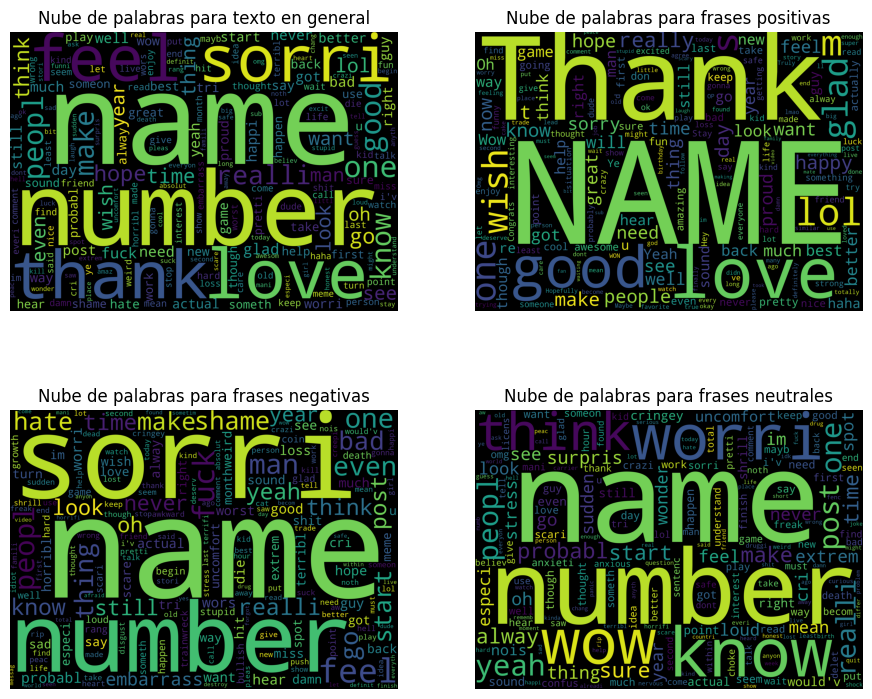

In [458]:
text = balanced_train_dataset.preprocessed_text
fig, ax = plt.subplots(figsize=(11, 9), nrows=2, ncols=2)
total_cloud = WordCloud(stopwords=STOPWORDS,
                        background_color="Black", 
                        collocations=False,
                        random_state=1,
                        width=2500,
                          height=1800
                         ).generate(" ".join(text))

ax[0, 0].axis('off')
ax[0, 0].set_title("Nube de palabras para texto en general")
ax[0, 0].imshow(total_cloud)


text = balanced_train_dataset[POSITIVE_id].text
total_cloud = WordCloud(stopwords=STOPWORDS,
                        background_color="Black",
                        random_state=1, 
                        collocations=False,
                        width=2500,
                          height=1800
                         ).generate(" ".join(text))

ax[0, 1].axis('off')
ax[0, 1].set_title("Nube de palabras para frases positivas")
ax[0, 1].imshow(total_cloud)


text = balanced_train_dataset[NEGATIVE_id].preprocessed_text
total_cloud = WordCloud(stopwords=STOPWORDS,
                        background_color="Black",
                        random_state=1, 
                        collocations=False,
                        width=2500,
                          height=1800
                         ).generate(" ".join(text))

ax[1, 0].axis('off')
ax[1, 0].set_title("Nube de palabras para frases negativas")
ax[1, 0].imshow(total_cloud)



text = balanced_train_dataset[NEUTRAL_id].preprocessed_text
total_cloud = WordCloud(stopwords=STOPWORDS,
                        background_color="Black",
                        random_state=1, 
                        collocations=False,
                        width=2500,
                          height=1800
                         ).generate(" ".join(text))

ax[1, 1].axis('off')
ax[1, 1].set_title("Nube de palabras para frases neutrales")
ax[1, 1].imshow(total_cloud)


# Model Training: 


In [459]:
# generamos los datos de entrenamiento con las clases balanceadas sin remover stop words y sin stemming.
X_train, _, y_train, _ = train_test_split(balanced_train_dataset["text"],balanced_train_dataset[[f"label_{i}" for i in range(28)]], shuffle=True, test_size=0.2, random_state=1)

In [460]:
# generamos los datos de entrenamiento para las clases balanceadas pero con los textos una vez aplicado el stemming y la eliminación de stop words.
X_train_prep, _, y_train_prep, _ = train_test_split(balanced_train_dataset["preprocessed_text"], balanced_train_dataset[[f"label_{i}" for i in range(28)]], shuffle=True, test_size=0.2, random_state=1)

In [461]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multioutput import ClassifierChain
import xgboost as xgb

# Explicacion del modelo: 
Para abordar un problema de multi labling es necesario considerar los datos. Según descubrimos en la matriz de correlación de los labels estos se encuentran correlacionados de manera moderada y baja. A pesar de esto para un modelo entrenado sería útil saber si se catalogó el texto como feliz, para así descartar la posibilidad de catalogarlo como enojado.

Existen varios métodos para realizar multilabeling:
<ol>
<li> Binary Relevance (BR): Los modelos de relevancia binaria crean |C| clasificadores para resolver un problema de labeling binario, la idea detrás de estos clasificadores es que por cada una de las posibles etiquetas se entrenará un clasificador i, el cual tiene como objetivo solamente clasificar la existencia de dicha etiqueta. De este modo, la salida general del modelo será la concatenación de las predicciones de los |C| clasificadores, haciendo que dichos modelos si puedan hacer multi labeling. 

La principal diferencia con un modelo One vs Rest (ovr) se encuentra en la cantidad de clasificaciones que dichos modelos pueden hacer, en un modelo ovr solamente puede elegirse una etiqueta, mientras que en un modelo de BR se pueden seleccionar múltiples etiquetas para un registro. 

La principal desventaja de este tipo de modelos es que no consideran la correlación existente entre las etiquetas. De este modo, estos modelos se pueden utilizar cuando la correlación entre etiquetas no es muy fuerte o no es del todo relevante para el problema. 
<li> Classifier Chains:
    El método implica encadenar clasificadores binarios en un orden específico, donde cada clasificador toma en un orden específico la salida del clasificador anterior. 
    Este método tiene la particularidad de tomar en consideración las correlaciones existentes entre los datos, ya que al tener las predicciones de los clasificadores pasados, puede considerar dichas predicciones para hacer la suya. En este ejemplo el clasificador puede utilizar el hecho de que un clasificador predijo que existe felicidad en el mensaje para hacer su predicción de la clase que le corresponde. 


<li> Label Powerset:
    El método de conjunto de potencia de etiquetas es un método que permite pasar un problema de multi etiquetas a un problema de multi clase, esto se considerando conjuntos de etiquetas como una clase propia. Este método utiliza las etiquetas muy correlacionadas para transformarlas en una clase propia que permita de este modo que el problema sea trabajado como un problema de multi clases. 

</ol>

Revisando el EDA, podemos explicar que la correlación existente entre los pares y tríos de features no es tan fuerte como para considerar que algunas de estas pueden unirse. Es más, re definir etiquetas múltiples como clases para este problema en específico no es útil, ya que pasar el modelo desde un problema de multi-etiquetas a uno de multi clases no permitirá que un texto pueda tener más de una etiqueta. De este modo, se cree que lo mejor es tratar dicho problema como uno de multilabeling. Para esto entrenaremos modelos Chain Classifier y Binary Relevance, con el objetivo de ver cuales serán los mejores. A modo de conjetura, los modelos ChainClassifier se especula que debieran obtener mejores resultados, esto ya que consideran las correlaciones existentes entre los textos, al contrario de los modelos de Binary Relevance. 

Para hacer la selección del modelo a utilizar para predecir finalmente los datos de prueba utilizaremos 3 clasificadores, dos simples pero bastante utilizados en problemas de NLP y otro que es actualmente de los mejores clasificadores de tipo árbol presente en la literatura. En específico, haremos uso de modelo de regresión logística, modelo de bayes ingenuo y XGBoost. La manera en la que se procederá será la siguiente, primero se enseñará a resolver el problema a los dos modelos más simples (regresión logística y bayes ingenuo), como dichos modelos son más simples se verá sus resultados en el conjunto de prueba (artificial) generado para entrenar estos modelos, si el modelo tipo chain Classifier fuese mejor que el modelo BR de dichos clasificadores, se entrenará el modelo XGBoost con dicha estructura. Esto se hace para reducir los tiempos de cómputo que presenta el notebook y se utiliza el siguiente raciocinio, como los modelos entrenados son más simples, el poder para separar el espacio en regiones es más acotado, de este modo, si un modelo básico tiene mejores resultados en una estructura que en otra un modelo más complejo también debiese seguir dicha tendencia. 

Otro punto importante a destacar es el hecho de que para entrenar el modelo se utilizarán los datos balanceados, pero como se busca testear los resultados en un conjunto de prueba que represente la realidad, el conjunto de testeo no tendrá este cambio de distribución y por ende serán datos que se encuentran desbalanceados por naturaleza. De este modo, las métricas mostradas a continuación son las que se obtienen cuando el modelo entrenado es expuesto a los datos reales y no a datos aumentados con técnicas de Data Augmentation.

Para simplificar la selección de los modelos entrenaremos todos los modelos más básicos con los textos habiendo realizado stemming y remoción de stop words.

# Explicación de las Métricas a utilizar:
Como hemos mostrado a través de este trabajo, las etiquetas presentes en el problema de analisis de textos están cláramente desbalanceadas. En específico, la clase neutral contiene la mayor cantidad de etiquetas ya sea por si sola como mezcladas con otras emociones. Esto hace que las métricas como F1-score, accuracy y recall no puedan ser applicadas directamente de esta manera al problema. Por esto es necesario aplicarlas mediante "micro-averagin", esto hace que en vez de calcular las métricas generales del modelo como un promedio de resultados de cada clase en particular, se aplica cada una de las fórmulas de accuracy, recall o F1-score tomando en consideración todos los TP, FP, TN, FN del problema, de este modo se obtiene una métrica global del desempeño de dicho modelo en vez de cada una en particular. 

Ahora introduciremos otras métricas que podrían ser utilizadas en este problema: 
<ol>
<li> Hamming Loss: 

En palabras simples esta función de pérdida contabiliza el porcentaje de error que presenta la predicción del modelo en comparación al valor real. De este modo, se puede ver que al utilizar la operador xor, solamente en los casos en que $y_{i,j}\neq{}z_{i,j}$ el valor de la métrica entregará uno.

$$\frac{1}{|N||L|}\sum_{i=1}^{|N|}\sum_{j=1}^{|L|}xor(y_{i,j}, z_{i,j})$$
La principal limitación con utilizar esta aproximación tiene relación con la cantidad de etiquetas que se están utilizando para este problema, como el problema presenta 28 etiquetas diferentes, donde a lo más las soluciones buscadas tendrán 3 o 4 etiquetas y el resto de las emociones no se encontrarán en el texto, la función de pérdida de Hamming podría tener artificialmente valores muy pequeños de error, esto ya que los errores del modelo serán pocos en comparación a la cantidad de etiquetas existentes. Por ejemplo, si el modelo se equivocara con una de las emociones la función de hamming entregaría $\frac{1}{29}\approx 0.035$. Este es un valor bastante alejado de 1, pero no significa que el modelo esté realizando una buena labor. 

<li>Indice de Jaccard: Este es una métrica la cual permite estimar la similitud entre conjuntos. Para realizar esto aplica la siguiente función: 

$$\frac{|A\cap{}B|}{|A\cup{}B|}$$

Esta función se lee como la fracción de las etiquetas en común en comparación a las etiquetas en total presentes en la predicción y los datos esperados. Dicha métrica al contrario de la métrica de Hamming tiene la particularidad de que no se ve afectada por la cantidad de etiquetas presentes en el problema, esto ya que el modelo no hará selección de tantas etiquetas y los datos reales a lo más tienen 3 etiquetas por registro. De este modo, no se tendrán problemas con la dimensión de dicha métrica.
<ol>


A pesar de ser las últimas dos métricas utilizadas en problemas de multi-etiqueta, ambas tienen las siguientes limitaciones: Ambas métricas son sensibles al imbalance en los datos. Además, en específico para el problema que se busca resolver otra limitación de ambas métricas (pero que se encuentra presente en todas las mencionadas hasta este punto) es el hecho de que no presenta jerarquía. La jerarquía en este problema es un aspecto muy importante de la predicción, esto se debe al hecho de que las etiquetas tienen cierta correlación o connotación la cual debe ser respetada para que el clasificador tenga buenos resultados. De este modo, ambas métricas solamente contabilizan las equivocaciones o aciertos de los modelos, pero no nos indican si el error fue en dos etiquetas diferentes que tienen connotaciones opuestas (esto sería un caso más preocupante a que si errara con etiquetas de connotación parecida).

Con esto en mente, las métricas a utilizar serán Accuracy, recall,  F1-score y el índice de jaccard.

In [462]:
# generamos una funcion que permita entrenar los modelos y entrear las metricas en testeo dado un diccionario, solamente se pide que la métrica sea compatible con 
#sklearn. 
def create_train_model(classifier_model, problem_transformer_model, x_train, y_train, x_test, y_test, metrics={"accuracy": metrics.accuracy_score,\
                        "Jaccard": lambda true, pred: metrics.jaccard_score(true, pred, average="micro"), "recall": lambda true, pred: metrics.recall_score(true, pred, average="micro"),\
                        "F1_score": lambda true, pred: metrics.f1_score(true, pred, average="micro")}):
    model_pipeline = Pipeline([
        # generamos un modelo tfid que considere los stop words en ingles, mantenga un maximo de feature de 2000 y considere dentro
        # de la generacion de features los ngramas de largo hasta 3. esto permitira que el vector de features no sea tan grande ademas de permitir 
        # la obtencion de inforamcion gracias a considerar ngramas.
                ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,3))),
                ('clf', problem_transformer_model(classifier_model)),
            ])
    # empezamos a medir el timpo 
    start = time.time()
    # ajustamos el modelo tipo pipeline
    model_pipeline.fit(x_train, y_train)
    # terminamos de contabilizar el tiempo de entrenamiento
    end = time.time()
    # predecimos las salidas
    y_pred = model_pipeline.predict(x_test)
    result_dict = {}
    # por cada metrica calculamos su valor:
    for a_metric_name, metric_fn in metrics.items():
        result_dict[a_metric_name] = metric_fn(y_test, y_pred)
    print(result_dict)
    print(f"Computation time: {end-start:.3f} [s]")
    #retornamos el modelo entrenado y el diccionario de resultados. 
    return model_pipeline, result_dict
    


In [463]:
Classifierdictionary = {}

# Chain classifier:

In [464]:
model = MultinomialNB(fit_prior=True, class_prior=None)
model, results = create_train_model(model, ClassifierChain, X_train_prep, y_train_prep, X_test_prep, y_test)
Classifierdictionary["CC_NB"] = model

{'accuracy': 0.07383091453582125, 'Jaccard': 0.0941387108933283, 'recall': 0.09819146844898761, 'F1_score': 0.1720782017052795}
Computation time: 2.948 [s]


In [465]:
model = LogisticRegression(solver='sag', random_state=1)
model, results = create_train_model(model, ClassifierChain, X_train_prep, y_train_prep, X_test_prep, y_test)
Classifierdictionary["CC_LR"] = model

{'accuracy': 0.45461875143976044, 'Jaccard': 0.3575867607010684, 'recall': 0.5033418517790447, 'F1_score': 0.5267976545622879}
Computation time: 22.472 [s]


# Binary Relevance: 

In [466]:
model = MultinomialNB(fit_prior=True, class_prior=None)
model, results = create_train_model(model, BinaryRelevance, X_train_prep, y_train_prep, X_test_prep, y_test)

{'accuracy': 0.06346463948398987, 'Jaccard': 0.07669389716482461, 'recall': 0.07843522704934146, 'F1_score': 0.1424618405784165}
Computation time: 32.398 [s]


In [467]:
model = LogisticRegression(solver='sag', random_state=1)
model, results = create_train_model(model, BinaryRelevance, X_train_prep, y_train_prep, X_test_prep, y_test)

{'accuracy': 0.2091683943791753, 'Jaccard': 0.23624172762103796, 'recall': 0.2666601140161195, 'F1_score': 0.3821934211453124}
Computation time: 1108.414 [s]


# Entrenar modelo más complejo:

Como se puede ver de los resultados, el modelo de Classifier Chain obtuvo mejores resultados tanto para el clasificador bayesiano como para el de regresión logística, en específico se puede ver como el modelo de regresión logística con Classifier Chains obtuvo mejoras considerables en todas las métricas en comparación a su contraparte con Binary relevance, por otro lado, los tiempos de entrenamiento son considerablemente mayores cuando se usa Binary Relevance, mientras que el modelo con classifier chains se demora 20 segundos en entrenar el modelo con Binary Relevance se demora cerca de 20 minutos. Esto hace que el método de binary relevance sea más costoso de entrenar sin generar una mejora sustantiva en el entrenamiento. De este modo, es posible ver como el uso de Chain Classifiers permite utilizar las predicciones anteriormente realizadas en clasificadores futuros generando mejores resultados que con Binary Relevance.  Por esta razón seguiremos con Chain Classifier para entrenar el modelo de XGB. 

Además, es posible ver que para este caso en específico el uso de stemming y eliminación de stop words de antemano generan cambios casi imperceptibles en los reusltado del modelo, dichos resultados mejoran en todas las métricas pero en porcetajes muy bajos como para ser considerados significantes.

A modo de análisis de las métricas se puede observar que el accuracy y el recall del método con el mejor modelo de XGBoost son bastante parecidos, tomando en consideración que ambos son micro average se puede considerar que el modelo no solamente logra clasificar la clase neutra, sino que además puede clasificar otras clases (esto gracias al efecto del oversampling y under sampling). El índice de Jaccard nos indica que en general el 40% de las selecciones realizadas por el modelo coinciden con las reales que presentan los labels. Además, podemos ver que el modelo obtuvo una precisión de cerca del 53% considerando los TP de todas las etiquetas, y que dentro de las que clasificó dentro de dicha etiqueta tuvo un recall del 57% aproximadamente, esto es un resultado considerable tomando en cuenta que se tienen 28 clases. De este modo, se obtuvo un F1 score del 60% lo que permite indicar que el modelo balancea correctamente entre ser preciso y recuperar las etiquetas en sus clases respectivas. 

In [468]:
# model without preprocessing: 
model = xgb.XGBClassifier(random_state=1, tree_method='gpu_hist')
model, results = create_train_model(model, ClassifierChain, X_train, y_train, X_test, y_test)
Classifierdictionary["no_proccesing_xgb"] = model

{'accuracy': 0.5315595484911311, 'Jaccard': 0.4213602162320111, 'recall': 0.5669353253390996, 'F1_score': 0.5928971578352263}
Computation time: 48.228 [s]


In [469]:
# model with preprocessing
model = xgb.XGBClassifier(random_state=1, tree_method='gpu_hist')
model, results = create_train_model(model, ClassifierChain, X_train_prep, y_train_prep, X_test_prep, y_test)
Classifierdictionary["processing_xgb"] =  model

{'accuracy': 0.5419258235429625, 'Jaccard': 0.4310762233145037, 'recall': 0.5775506192254767, 'F1_score': 0.6024504024196443}
Computation time: 48.433 [s]


Como se puede ver, la conjetura inicial sobre como un modelo más sofisticado se ajustaría mejor a una zona de clasificación que un modelo más básico fue cierta, en específico se pueden ver mejoras de cercanas a los 2 o 3 puntos en todas las métricas. Con esto se puede decir que la mezcla de Chain Classifiers con XGB permite entrenar modelos en tiempos acotados (51 segundos aproximadamente) y que mejoran considerablemente los resultados obtenidos por el modelo en comparación a su par con Binary Relevance.

También es posible decir que el uso de balanceo de clases permitió que el modelo aprendiera otras clases que no fuesen la mayoritaria, permitiendo de este modo una buena clasificación. 

# Indicador de Satisfacción: 
Para generar un indicador de satisfacción de cómo funciona el modelo, es importante considerar algunos aspectos importantes. Por ejemplo, a través de este trabajo hemos notado que dada la estructura de las etiquetas existen 3 "súper etiquetas" que engloban los distintas etiquetas encontradas. Estas son: Positivos, Neutrales y Negativos. La forma en la que se pudo generar esta selección tiene relación con la connotación que se le da a la palabra que genera la etiqueta. De este modo, palabras como admiración u orgullo son palabras de connotación positiva, mientras que palabras como tristeza o dolor son palabras que tienen una connotación más negativa. Dentro de esta catalogación también tendremos palabras que tienen una catalogación "neutral" dicha definición tiene relación con palabras que a priori sin un contexto no se sabe si son de connotación negativa o positiva. Por ejemplo, la palabra nervioso puede ser tanto por felicidad o por preocupación, de este modo no es posible entregarle una connotación directa a estas palabras. 

Habiendo ya explicado las "súper etiquetas" definidas a través de este problema, una condición que marca el funcionamiento del clasificador tiene relación con la jerarquía de las etiquetas, es decir, que el nivel de error del modelo es distinto dependiendo de la etiqueta. Por ejemplo, no son de interés soluciones que den como etiquetas "triste" y "admiración". Ya que es poco probable encontrar textos en que las personas que lo escribieron efectivamente sintieran ambas emociones. 

De este modo, definimos el indicador de emociones de la siguiente manera: 
Sea $G$ un vector predicho por el modelo $M$, $P$ un conjunto de etiquetas con connotación positiva, $N$ un conjunto de etiquetas con connotación neutra, $F$
un conjunto de etiquetas con connotación negativa y $T$ el vector que representa las etiquetas reales que presenta el texto. Se define el conjunto $O_{t_{i}}$ como el conjunto al que pertenece la etiqueta real del registro i-esimo.La métrica de satisfacción se mide como: 
$$S(t, g) = \frac{\sum_{j}^{|C|}L(t_{j}, g_{j})}{\sum_{k}^{|C|}t_{k}}$$

Donde $L(t, l)$ se define como: 

$$L(t, l) = \begin{cases}
			0 & \text{if t = g}\\
			0.25 & \text{if t}\neq\text{ g, and g} \in{}O_{t}\\
			0.5 & \text{if t}\neq\text{ g, and g}\in\text{N}\\
            1, & \text{otherwise}
		 \end{cases}$$

De este modo, se define la Satisfacción general del modelo como:

$$\frac{1}{N}\sum_{i}^{N}S(t_{i}, l_{i})$$

La métrica anteriormente mencionada tiene la particularidad de considerar regiones de soluciones más correctas que otras, todo dependiendo de la "súper etiqueta" a la que esta pertenezca. De este modo, esta métrica calcula el promedio de las medidas de satisfacción particulares de cada registro. Donde para cada registro la manera de calcular la satisfacción es la siguiente: primero se revisa si la predicción hecha por el modelo y del vector real es el mismo. Si lo son se le entregará un valor de 0 a dicha predicción. En caso de que la predicción sea distinta pero ambas se encuentren en la misma "súper etiqueta", entonces se le entregará un valor de 0.25 a dicha predicción, ya que ambas predicciones tienen la misma connotación. Ahora, si la predicción es distinta y el modelo predice esa etiqueta como neutra, entonces se le dará un valor de 0.5 al modelo. Por último, en caso de que las connotaciones sean opuestas se le entregará un valor de 1 a dicha predicción. Una vez realizado este proceso componente a componente, se procede a normalizar por la cantidad de etiquetas $|t|$ que corresponden a la cantidad de etiquetas reales del registro. Esto hace que el valor de la métrica propuesta se encuentre entre 0 y 1, siendo 0 el valor cuando la predicción es perfecta.

Un caso interesante es cuando t tiene más etiquetas que g o vice versa. En estos casos por cada elemento faltante o sobrante en la clasificación a la satisfacción se le sumará un valor de 1. 



In [470]:
# guardamos las etiquetas como una matriz de forma [1, 28]
label_matrix = np.array(labels)[None, ...].astype(str)

# dada un valor t que representa los sentimientos reales
# de esa instancia, la funcion get belonging representa la 
#Ot, es decir el conjutno de super-etiqueta al que pertence t. 
def get_belonging(t):
    if t in POSITIVE_LABELS:
        return POSITIVE_LABELS
    elif t in NEGATIVE_LABELS:
        return NEGATIVE_LABELS
    else: 
        return NEUTRAL_LABELS

# funcion que dadas prediccions hechas por el modelo (g_list) y 
# ti siendo una coordenada de los valores reales de t, entrega el valor 
# que obtiene la metrica para ese valor de t. 
def get_loss_per_prediction(g_list, ti):
    Ot = get_belonging(ti)
    loss_mapping = []
    for a_g in g_list: 
        if a_g in Ot:
            loss_mapping.append(0.25)
        elif a_g in NEUTRAL_id:
            loss_mapping.append(0.5)
        else: 
            loss_mapping.append(1)
    return loss_mapping


# calcula la funcion S(t, g)
def particular_satisfaction(t_set, g_set):
    """
    Funcion de satisfaccion particular: 
    inputs: 
    t (array): valores reales para el registro
    g (array): valores predichos por el modelo para el registro
    output: 
        valor de satisfaccion en particular para un registro en especifico
    """
    intersection_set = t_set.intersection(g_set)
    t_left_over = list(t_set-intersection_set)
    g_left_over = list(g_set-intersection_set)
    satisfaction = 0
    for a_t in t_left_over:
        if len(g_left_over)>0:
            loss_mapping = get_loss_per_prediction(g_left_over, a_t)
            min_loss_index = np.argmin(loss_mapping)
            satisfaction += loss_mapping[min_loss_index]
            g_left_over.pop(min_loss_index)
        else: 
            satisfaction+=1
    satisfaction += len(g_left_over)
    return satisfaction/len(t_set)

# calcula la metrica de manera general
# es decir para cada registro calcula su satisfacción y luego 
# realiza un promedio sobre estos. 
def Satisfaction_metric(t, g):
    global_satisfaction = 0
    t = t.astype(bool)
    g = g.astype(bool)

    t_label = (t*label_matrix).to_numpy().tolist()
    g_label = (g*label_matrix).to_numpy().tolist()
    for a_t_label, a_g_label in zip(t_label, g_label):
        t_set = set([label for label in a_t_label if label != ''])
        g_set = set([label for label in a_g_label if label != ''])
        global_satisfaction += particular_satisfaction(t_set, g_set)
    return global_satisfaction/len(t_label)



In [474]:
predicted_outputs = [pd.DataFrame(m.predict(X_test), columns= [f"label_{i}" for i in range(28)])  if k == "no_proccesing_xgb" else pd.DataFrame(m.predict(X_test_prep), columns= [f"label_{i}" for i in range(28)]) for k, m in Classifierdictionary.items()]

In [475]:
for k, y_pred in zip(Classifierdictionary.keys(), predicted_outputs): 
    print(f"{k}: {Satisfaction_metric(y_test, y_pred)}")

CC_NB: 0.914199877140444
CC_LR: 0.41168749520079845
no_proccesing_xgb: 0.34484661752284407
processing_xgb: 0.3345403324886739


Analizando los resultado obtenidos al utilizar la métrica propuesta podemos ver que el modelo final con pre procesamiento mediante stemming y eliminación de las stop words tiene mejor desempeño que los otros, en específico en comparación con su par sin preprocesamiento su valor de métrica es levemente mejor. Ahora, es importante ver como los resultado obtenidos avalan los resultados expuestos en las métricas previamente mostradas, ya que este sigue la misma tendencia. 

De este modo, podemos ver como la métrica de satisfacción generada para este problema es de 0.334, esto es mayor al error considerado por equivocarse de etiqueta pero confundiéndolo por otra con una super etiqueta de la misma connotación y menor que el error por equivocarse de etiqueta con la super-etiqueta neutral, esto es muy importante, ya que nos permite avizorar que el modelo entrenado logra mantener las relaciones existentes almenos confundiendo en algunos casos con otras etiquetas que pueden ser neutras o positivas pero no opuestas al sentimiento presente en ellas. En parte el efecto se debe a la predominancia de la etiqueta neutra, esta es muy preponderante dentro del dataset y existen registros con mucho menores datos, donde incluso dichos modelos tuvieron que repetir su valor varias veces dentro de un mismo dataset ya que se tenían muy pocos registros con sus valores, esto genera problemas en el aprendizaje ya que no se permite definir correctamente las regiones de cada una de las clases debido a la falta de información (esto además considerando que copiar varias veces un registro no genera más información dentro de los datos, solamente hace que la que ya está se encuentre más presente en el dataset).

A modo de ejemplo a continuación se grafica la matriz de correlación generada por el modelo, dentro de esta podemos ver como las palabras que tienen misma "super-etiqueta" se encuentran más correlacionadas que las que no, además podemos ver correlaciones que no apreciabamos directamente en los datos y esto se debe particularmente a asociaciones (posiblemente artificiales) que encontró el modelo entre dichas etiquetas. Finalmente se puede ver como el modelo entrenado logra aprender las relaciones básicas entre las distintas etiquetas, condición muy importante para que las predicciones que haga este sean confiables y consistentes con el problema, ya que muestra cómo las distintas etiquetas están correlacionadas con etiquetas parecidas y no con cualquiera. 



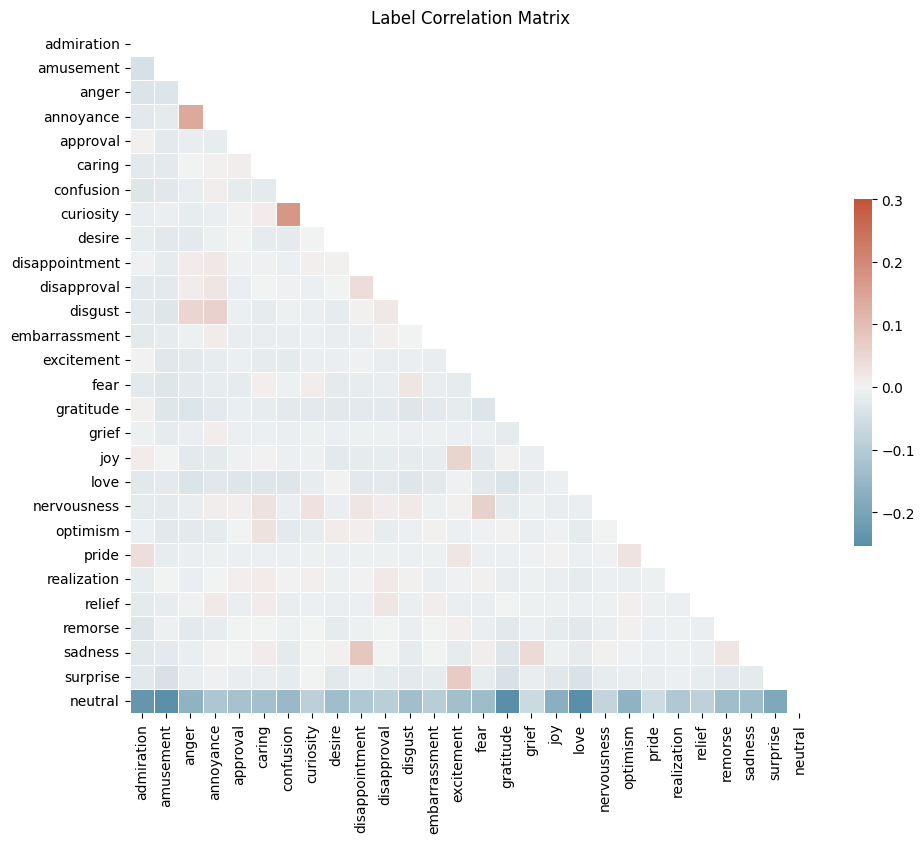

In [478]:
y_pred = pd.DataFrame(Classifierdictionary["processing_xgb"].predict(X_test_prep), columns= [f"label_{i}" for i in range(28)])
generate_correlation_matrix(y_pred,labels=labels)

# Test set: 

In [479]:
text = preprocess_text(test_dataset.text)
test_dataset["preprocessed_text"] = text
y_pred = pd.DataFrame(Classifierdictionary["processing_xgb"].predict(test_dataset.preprocessed_text), columns=[f"label_{i}" for i in range(28)])

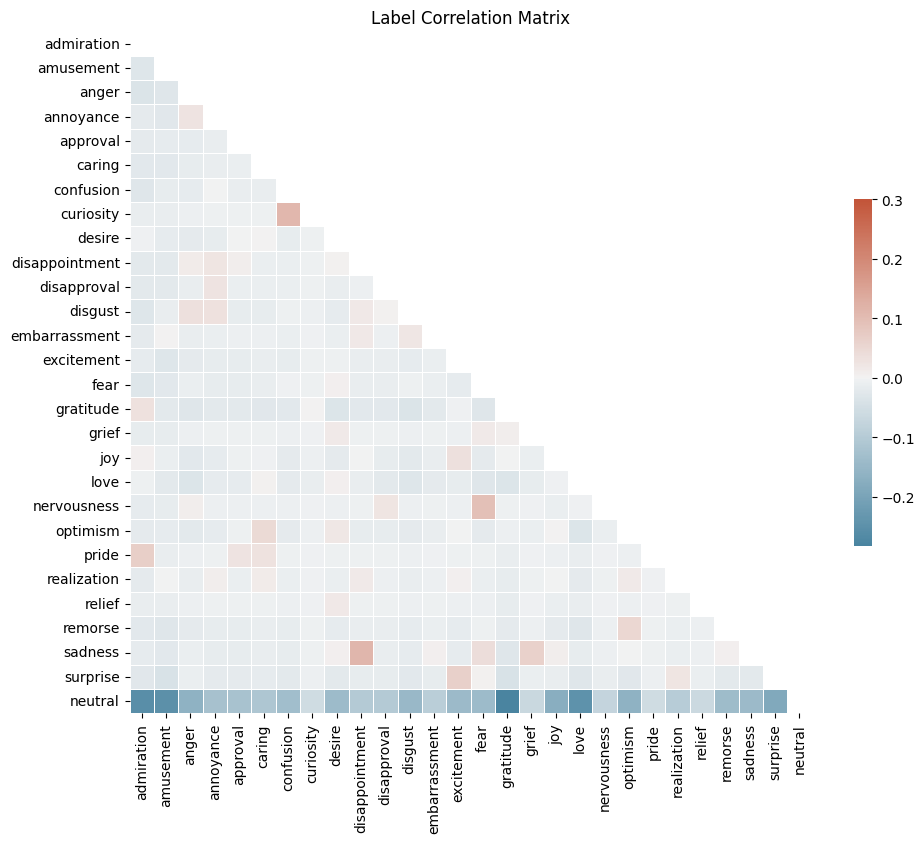

In [480]:
generate_correlation_matrix(y_pred, labels=labels)

A modo de cierre se puede ver como los resultados predichos por el modelo presentan correlaciones negativas bajas entre la etiqueta neutra y las otras etiquetas, además existe correlación positiva entre moderada y baja en casos donde las emociones si tienen un relación. Esto permite hasta cierto punto dar confianza en los resultados encontrados por el modelo aunque no se pueda comparar con las etiquetas reales de este dataset.

In [481]:
def save_file(data_frame,y_pred):
    data_frame["emotion"] = y_pred.apply(lambda x: ",".join([str(i) for i in range(len(x.to_numpy().tolist())) if x[f"label_{i}"] ==1]), axis=1)
    df_2_save = data_frame[["text", "id", "emotion"]]
    df_2_save.to_csv("text_classification_test.csv", index=False)
    return y_pred

In [482]:
y_pred = save_file(test_dataset, y_pred)

## Preguntas Adicionales:
1.	¿De qué manera se puede complementar la solución? 

Una manera en la que se podría complementar la solución es haciendo uso de este modelo de sentiment analysis para generar métodos de recomendación de productos. Esto podría ser por ejemplo con un post de instagram. Como la empresa es de marketing se podría analizar los sentimientos generados en los comentarios de cada una de las publicaciones generadas por la empresa. Esto permitiría abrir dos aristas interesantes, la primera es entender el comportamiento del público al que se dirige la empresa mediante los post, entendiendo las emociones que generan en ellos, de este modo se podría mejorar el análisis de mercado realizado e incluso mejorar las conversiones de la empresa, ya que esto permitiría generar post que solamente generen cierto tipo de emociones en los clientes. 

A pesar de no saberse en concreto el proyecto de la empresa, en caso de que la empresa quisiese entender el sentir de su público también se podría implementar un análisis automático de texto el cual permita desglosar en palabras claves los sentimientos que se vean envueltos en ciertas etiquetas que ésta defina. Por ejemplo, entender que patrones existen entre las personas que escriben comentarios tristes o nerviosos sobre los post que hacen. 

2.	¿Cómo se podría simplificar la tarea?

Una manera de simplificar la tarea encargada tiene directa relación al trabajo que se haga con los clientes, esto se debe a que la clasificación realizada por la empresa podría perfectamente no estar alineada con el objetivo que buscan ellos con esta tarea, por lo que una posible simplificación sería hablar con los clientes y definir junto a ellos un conjunto más acotado y menos coincidente de etiquetas que esté directamente relacionado con la tarea que ellos buscan resolver. En dicho caso la resolución podría permitir simplificar el problema a uno de clasificación multi clase en vez de uno de clasificación de múltiples etiquetas. Además de permitir bajar la cantidad de clases de 28 a una cantidad más acotada. 

Ahora, en caso de que la naturaleza del problema que se busca resolver sea efectivamente multi etiqueta, entonces es necesario definir correctamente las clases que se busca clasificar, de manera de reducir su número y asi tener un conjunto más acotado para clasificar, lo cual simplificaría el problema ya que los modelos generados no requerirían tantos clasificadores, sino que necesitarían entrenar una menor cantidad. 

Una última forma de simplificar el problema sería mediante el uso de features entrenados, la mayoría de los modelos de hoy en día utilizan características que se aprenden con redes neuronales. Dichas características se encuentran de manera open-source y permiten entregar características muy completas del lenguaje. En específico no afectaría la velocidad de la solución ya que los modelos de redes neuronales no presentan lentitud al momento de realizar inferencia, por lo que se ganaría en características más completas de los textos a catalogar. En específico esto permitiría simplificar el problema en un aspecto muy importante, no sería necesario realizar tanto pre-procesamiento de los datos, ya que la mayoría de estos métodos ya vienen con tokenizadores incorporados, por lo que se podría hacer perfectamente un ensamble entre estos generadores de features y xgboost para así clasificar dentro de un espacio de características que no solamente considera las palabras sino que su inserción en el contexto. 

3.	¿Cuáles pueden ser las limitaciones, riesgos, sesgos de los modelos al implementar este tipo de soluciones? 

Como se vió a través de este trabajo, para realizar las características de cada texto se utilizó un modelo de TF-id el cual hace uso de la frecuencia de ocurrencia de cada palabra para generar un diccionario con los valores de relevancia de dicho término en el diccionario. Entre sus principales limitaciones se encuentra que este tipo de modelos no considera el contexto de la palabra al momento de realizar su representación en el espacio de características, eso hace que la representación que se tiene de ella sea acotada y no completamente robusta, ya que la misma palabra puede cambiar completamente su significado dependiendo del contexto. Otra limitación presente en este tipo de modelos es la cantidad de clasificadores que hay que entrenar, en específico el problema tenía 28 características haciendo que fuese necesario entrenar 28 clasificadores, esto claramente genera un cuello de botella al momento de buscar modelos que se entrenen de manera fácil y rápida, ya que ahora no solamente hay que considerar el balance de los datos, sino que además la cantidad de clasificadores que habrá que usar. 

Un sesgo del modelo es que para generar el vector de caracterización hace uso de textos o escritos iniciales, los cuales permiten tener una distribución de probabilidad sobre las palabras que se encuentra definida. De este modo, si tenemos una bolsa de palabras generada con textos solamente de ciencias la clasificación que hagamos de esta no será la adecuada cuando queramos analizar el escrito de un humanista. Esto tiene efectos claros en cómo se definen ciertos sentimientos en un texto. Dicho efecto se debe tanto a la distribución de textos con los cuales se entrena como así también al hecho de que el diccionario de palabras es determinístico dependiendo de los textos iniciales que se le entreguen. Este sesgo no ocurre en los modelos más nuevos de NLP ya que estos son pre entrenados en tareas cuyo objetivo es solamente aprender el lenguaje, de este modo, el espacio de características no se encuentra definido de manera determinística por los textos que lo componen, sino que se encuentra limitado por la cantidad de textos que pueda usar para aprender.  

Los riesgos presentes en este tipo de modelos dependen más que nada de la aplicación que se les de, en específico, si el modelo fuese utilizado para una tarea de alto impacto para una empresa el principal riesgo sería que este se viera enfrentado a un texto escrito de una manera diferente a la que entreno. Esto se debe principalmente a lo expuesto anteriormente, al depender solamente de la ocurrencia y no así del contexto, textos que se escapen de la distribución de entrenamiento harán que una frase común para un humano sea entendida de una manera completamente diferente para este modelo. Es por esto que se debe considerar que los textos con los cuales dichos modelos entrenen sean de lo más variado posible, ya que de no ser así es muy probable caer en este tipo de problemas. De este modo el principal riesgo de este tipo de modelos es que se equivoquen y por ende el nivel de riesgo está definido por la importancia de la tarea que realiza el modelo. 

4.	¿Qué otras cosas hay que considerar al momento de implementar un proyecto como este?

Las principales consideraciones que hay que tener al momento de realizar un modelo como este es la definición del problema. Es importante definir desde un inicio de manera correcta si lo que se busca es clasificación multi clase o multi etiqueta. Esto se debe a que las maneras de resolver dichas tareas son diferentes y por ende deben ser tratadas como tal. En específico un modelo multi clases no necesariamente necesita entrenar $|C|$ clasificadores binarios en cascada o independientes, esto ya que existen modelos que permiten clasificaciones multi clase sin necesidad de dicho modelo sea reformulado a un one vs rest.  por lo que los tiempos de cómputo se reducen y la simplificación del problema es mayor. Además, esto genera que la cantidad de etiquetas que sea recomendable usar disminuya, ya que usar la menor cantidad de etiquetas necearias hace que el problema de clasificación se simplifique bastante. 

En específico, el tipo de modelos implementado funcionan muy bien en textos donde no afecte mucho el contexto y por frecuencia pueda ser posible entender el contenido del texto. Bajo esta línea al usar modelos que utilicen bolsas de palabras se vuelve necesario entrenar dichos modelos con textos variados, de manera de tener una buena representación del lenguaje. Es por esto que una consideración importante es saber entender el problema para saber si los textos que se analizarán cumplen con esta condición de simplicidad o no. De este modo, la elección del método para calcular las características del texto es muy importante ya que los clasificadores explotarán las representaciones que entreguen estas características además del clasificador utilizado para solucionar el problema. 

Por último, es importante tratar de que los conjuntos de datos para entrenar no se encuentren muy desbalanceados, ya que esto genera que los resultados encontrados se vean perjudicados por dicho desbalance. En específico, mientras mayor sea la cantidad de clases generadas, mayor será la probabilidad de que alguna de dichas etiquetas se presente en menor cantidad en los datos haciendo así que se generen desbalances que pueden ser artificiales, generados simplemente por la elección de las clases a catalogar. Además, en muchos casos la falta de textos catalogados es lo que ha generado el alzamiento de métodos de pre-entrenamiento en modelos más actuales de nlp, ya que estos hacen uso de textos no etiquetados y utilizan técnicas sobre este que permitan usarlo a pesar de que no estén catalogados.  
